## 聚体判断标准

> 暂时无视Cleaned PDB

1. 单体：PDB中只有一条蛋白链
2. 同聚体：PDB中的一对链属于同一蛋白且覆盖范围接近；属于同一蛋白但是覆盖范围不接近的注释掉
3. 异聚体：PDB中一对链属于不同蛋白

## Clean PDB

### Entry level

1. PDB中存在一条未知蛋白链(或是一条链的最佳匹配蛋白的identity不符阈值)即注释掉该Entry
2. PDB中存在UNK/CA-ONLY即注释掉该Entry
3. PDB实验方法/resolution不符要求即注释
4. SIFTS Mapping中的需delete的map
5. PDB中存在DNA/RNA杂交链的Entry需注释

### Chain level

1. PDB链的ATOM_LEN不符阈值
    * ATOM_LEN = OBSERVED_RES_LEN - OBSERVED_MODIFIED_RES_LEN

In [149]:
import sys
sys.path.append(r'C:\GitWorks\Muta3DMaps')
from Muta3DMaps.core.pdbe.decode import ProcessSIFTS, SeqRangeReader, ProcessEntryData
from Muta3DMaps.core.uniprot.decode import UniProtFASTA
from Muta3DMaps.core.retrieve.fetchFiles import UnsyncFetch
from tablib import Dataset
import pandas as pd
import pyexcel as pe
import numpy as np
from pprint import pprint
import ujson as json
from collections import Counter, defaultdict
from time import perf_counter

In [8]:
UnsyncFetch.use_existing = True

In [11]:
ProcessSIFTS.init_logger()

In [12]:
dfrm = ProcessSIFTS.main(
    filePath=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\uniprot_pdb.tsv',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data',
    related_unp={'Q9BQ50', 'P51587', 'P0DP91'})

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.21it/s]
2020-02-21 14:25:09,469 ProcessSIFTS INFO 5 ids downloaded in 1.56s


In [161]:
# dfrm.to_csv(r'C:\Users\Nature\Downloads\dfrm_0221.tsv', sep='\t', index=False)
sheet = pe.get_sheet(file_name=r'C:\Users\Nature\Downloads\dfrm_0221.tsv', name_columns_by_row=0)
sheet

UniProt,chain_id,end,entity_id,identifier,identity,is_canonical,name,pdb_id,start,struct_asym_id,sifts_pdb_range,sifts_unp_range,Entry,pdb_GAP_list,unp_GAP_list,var_list,delete,var_0_count,unp_GAP_0_count,group_info,sifts_unp_pdb_var,sifts_range_tage
P53350,A,"{""author_residue_number"":null,""author_insertion_code"":"""",""residue_number"":245}",1,PLK1_HUMAN,0.988,True,PLK1_HUMAN,6gy2,"{""author_residue_number"":null,""author_insertion_code"":"""",""residue_number"":7}",A,"[[7,245]]","[[365,603]]",P53350,[],[],[0],False,1,0,1,0,Safe
P53350,B,"{""author_residue_number"":null,""author_insertion_code"":"""",""residue_number"":245}",1,PLK1_HUMAN,0.988,True,PLK1_HUMAN,6gy2,"{""author_residue_number"":null,""author_insertion_code"":"""",""residue_number"":7}",B,"[[7,245]]","[[365,603]]",P53350,[],[],[0],False,1,0,1,0,Safe
P51587,C,"{""author_residue_number"":210,""author_insertion_code"":"""",""residue_number"":17}",2,BRCA2_HUMAN,1,True,BRCA2_HUMAN,6gy2,"{""author_residue_number"":null,""author_insertion_code"":"""",""residue_number"":1}",C,"[[1,17]]","[[194,210]]",P51587,[],[],[0],False,1,0,1,0,Safe
P51587,D,"{""author_residue_number"":210,""author_insertion_code"":"""",""residue_number"":17}",2,BRCA2_HUMAN,1,True,BRCA2_HUMAN,6gy2,"{""author_residue_number"":null,""author_insertion_code"":"""",""residue_number"":1}",D,"[[1,17]]","[[194,210]]",P51587,[],[],[0],False,1,0,1,0,Safe
P51587,I,"{""author_residue_number"":2054,""author_insertion_code"":"""",""residue_number"":28}",2,BRCA2_HUMAN,0.893,True,BRCA2_HUMAN,6hqu,"{""author_residue_number"":1226,""author_insertion_code"":"""",""residue_number"":1}",I,"[[1,28]]","[[1226,1253]]",P51587,[],[],[0],False,1,0,1,0,Safe
P51587,J,"{""author_residue_number"":2054,""author_insertion_code"":"""",""residue_number"":28}",2,BRCA2_HUMAN,0.893,True,BRCA2_HUMAN,6hqu,"{""author_residue_number"":1226,""author_insertion_code"":"""",""residue_number"":1}",J,"[[1,28]]","[[1226,1253]]",P51587,[],[],[0],False,1,0,1,0,Safe
P51587,K,"{""author_residue_number"":2054,""author_insertion_code"":"""",""residue_number"":28}",2,BRCA2_HUMAN,0.893,True,BRCA2_HUMAN,6hqu,"{""author_residue_number"":1226,""author_insertion_code"":"""",""residue_number"":1}",K,"[[1,28]]","[[1226,1253]]",P51587,[],[],[0],False,1,0,1,0,Safe
P51587,L,"{""author_residue_number"":2054,""author_insertion_code"":"""",""residue_number"":28}",2,BRCA2_HUMAN,0.893,True,BRCA2_HUMAN,6hqu,"{""author_residue_number"":1226,""author_insertion_code"":"""",""residue_number"":1}",L,"[[1,28]]","[[1226,1253]]",P51587,[],[],[0],False,1,0,1,0,Safe
P51587,M,"{""author_residue_number"":2054,""author_insertion_code"":"""",""residue_number"":28}",2,BRCA2_HUMAN,0.893,True,BRCA2_HUMAN,6hqu,"{""author_residue_number"":1226,""author_insertion_code"":"""",""residue_number"":1}",M,"[[1,28]]","[[1226,1253]]",P51587,[],[],[0],False,1,0,1,0,Safe
P51587,N,"{""author_residue_number"":null,""author_insertion_code"":"""",""residue_number"":28}",2,BRCA2_HUMAN,0.893,True,BRCA2_HUMAN,6hqu,"{""author_residue_number"":1226,""author_insertion_code"":"""",""residue_number"":1}",N,"[[1,28]]","[[1226,1253]]",P51587,[],[],[0],False,1,0,1,0,Safe


In [171]:
with open(r'C:\Users\Nature\Downloads\dfrm_0221.tsv', 'r') as fh:
    imported_data = Dataset().load(fh, format='tsv')

In [165]:
records = pe.get_records(file_name=r'C:\Users\Nature\Downloads\dfrm_0221.tsv', name_columns_by_row=0)
records

[OrderedDict([('UniProt', 'P53350'),
              ('chain_id', 'A'),
              ('end',
               '{"author_residue_number":null,"author_insertion_code":"","residue_number":245}'),
              ('entity_id', 1),
              ('identifier', 'PLK1_HUMAN'),
              ('identity', 0.988),
              ('is_canonical', 'True'),
              ('name', 'PLK1_HUMAN'),
              ('pdb_id', '6gy2'),
              ('start',
               '{"author_residue_number":null,"author_insertion_code":"","residue_number":7}'),
              ('struct_asym_id', 'A'),
              ('sifts_pdb_range', '[[7,245]]'),
              ('sifts_unp_range', '[[365,603]]'),
              ('Entry', 'P53350'),
              ('pdb_GAP_list', '[]'),
              ('unp_GAP_list', '[]'),
              ('var_list', '[0]'),
              ('delete', 'False'),
              ('var_0_count', 1),
              ('unp_GAP_0_count', 0),
              ('group_info', 1),
              ('sifts_unp_pdb_var', 0),
    

In [169]:
data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))))
t0 = perf_counter()
for i in range(len(sheet)):
    cur_dict = data[sheet[i, 'pdb_id']][sheet[i,'Entry']][sheet[i,'entity_id']][sheet[i,'chain_id']][sheet[i,'UniProt']]
    for key in ('identity', 'sifts_unp_range', 'sifts_pdb_range', 'sifts_range_tage', 'delete'):
        cur_dict[key] = sheet[i,key]
print(perf_counter()-t0)

0.001352999999653548


In [191]:
# BEST
data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))))
t0 = perf_counter()
for record in records:
    cur_dict = data[record['pdb_id']][record['Entry']][record['entity_id']][record['chain_id']][record['UniProt']]
    for key in ('identity', 'sifts_unp_range', 'sifts_pdb_range', 'sifts_range_tage', 'delete'):
        cur_dict[key] = sheet[i,key]
print(perf_counter()-t0)

0.00041119999877992086


In [190]:
data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))))
t0 = perf_counter()
for record in imported_data.dict:
    cur_dict = data[record['pdb_id']][record['Entry']][record['entity_id']][record['chain_id']][record['UniProt']]
    for key in ('identity', 'sifts_unp_range', 'sifts_pdb_range', 'sifts_range_tage', 'delete'):
        cur_dict[key] = sheet[i,key]
print(perf_counter()-t0)

0.001252300000487594


In [192]:
# pprint(nujson.dumps(data, indent=4))
json.dumps(data, ident=2)

TypeError: 'ident' is an invalid keyword argument for this function

In [193]:
?json.dumps

In [39]:
dfrm[['pdb_id', 'Entry', 'entity_id', 'chain_id' ,'UniProt', 'identity','sifts_unp_range', 'sifts_pdb_range', 'sifts_range_tage', 'delete']]

,pdb_id,Entry,entity_id,chain_id,UniProt,identity,sifts_unp_range,sifts_pdb_range,sifts_range_tage,delete
0,6gy2,P53350,1,A,P53350,0.988,"[[365,603]]","[[7,245]]",Safe,False
1,6gy2,P53350,1,B,P53350,0.988,"[[365,603]]","[[7,245]]",Safe,False
2,6gy2,P51587,2,C,P51587,1.000,"[[194,210]]","[[1,17]]",Safe,False
3,6gy2,P51587,2,D,P51587,1.000,"[[194,210]]","[[1,17]]",Safe,False
4,6hqu,P51587,2,I,P51587,0.893,"[[1226,1253]]","[[1,28]]",Safe,False
5,6hqu,P51587,2,J,P51587,0.893,"[[1226,1253]]","[[1,28]]",Safe,False
6,6hqu,P51587,2,K,P51587,0.893,"[[1226,1253]]","[[1,28]]",Safe,False
7,6hqu,P51587,2,L,P51587,0.893,"[[1226,1253]]","[[1,28]]",Safe,False
8,6hqu,P51587,2,M,P51587,0.893,"[[1226,1253]]","[[1,28]]",Safe,False
9,6hqu,P51587,2,N,P51587,0.893,"[[1226,1253]]","[[1,28]]",Safe,False


### 1N0W_A with Q06609-2

```clustal
CLUSTAL O(1.2.4) multiple sequence alignment


1N0W:A|PDBID|CHAIN|SEQUENCE      ------------SEIIQITTGSKELDKLLQGGIETGSITEMFGEFRTGKTQICHTLAVTC
sp|Q06609-2|RAD51_HUMAN          MAMQMQLEANADTSVEEESFGPQPISRLEQCGINANDVKKLEE-------AGFHTVEAVA
                                             :.: : : * : :.:* * **::..:.::            **: ...

1N0W:A|PDBID|CHAIN|SEQUENCE      QLPIDRGGGEGKAMYIDTEGTFRPERLLAVAERYGLSGSDVLDNVAYARAFNTDHQTQLL
sp|Q06609-2|RAD51_HUMAN          YA------PKKELINIKGISEAKADKILAVAERYGLSGSDVLDNVAYARAFNTDHQTQLL
                                          : : : *.  .  : :::*********************************

1N0W:A|PDBID|CHAIN|SEQUENCE      YQASAMMVESRYALLIVDSATALYRTDYSGRGELSARQMHLARFLRMLLRLADEFGVAVV
sp|Q06609-2|RAD51_HUMAN          YQASAMMVESRYALLIVDSATALYRTDYSGRGELSARQMHLARFLRMLLRLADEFGVAVV
                                 ************************************************************

1N0W:A|PDBID|CHAIN|SEQUENCE      ITNQVVAQVDGAAMFAADPKKPIGGNIIAHASTTRLYLRKGRGETRICKIYDSPCLPEAE
sp|Q06609-2|RAD51_HUMAN          ITNQVVAQVDGAAMFAADPKKPIGGNIIAHASTTRLYLRKGRGETRICKIYDSPCLPEAE
                                 ************************************************************

1N0W:A|PDBID|CHAIN|SEQUENCE      AMFAINADGVGDAKD
sp|Q06609-2|RAD51_HUMAN          AMFAINADGVGDAKD
                                 ***************
```

### 1N0W_A with Q06609 Entry

```clustal
CLUSTAL O(1.2.4) multiple sequence alignment


1N0W:A|PDBID|CHAIN|SEQUENCE      ------------------------------------------------------------
sp|Q06609|RAD51_HUMAN            MAMQMQLEANADTSVEEESFGPQPISRLEQCGINANDVKKLEEAGFHTVEAVAYAPKKEL
sp|Q06609-2|RAD51_HUMAN          MAMQMQLEANADTSVEEESFGPQPISRLEQCGINANDVKKLEEAGFHTVEAVAYAPKKEL
sp|Q06609-3|RAD51_HUMAN          MAMQMQLEANADTSVEEESFGPQPISRLEQCGINANDVKKLEEAGFHTVEAVAYAPKKEL
sp|Q06609-4|RAD51_HUMAN          MAMQMQLEANADTSVEEESFGPQPISRLEQCGINANDVKKLEEAGFHTVEAVAYAPKKEL
                                                                                             

1N0W:A|PDBID|CHAIN|SEQUENCE      -------------------------------------SEIIQITTGSKELDKLLQGGIET
sp|Q06609|RAD51_HUMAN            INIKGISEAKADKILAEAAKLVPMGFTTATEF-HQRRSEIIQITTGSKELDKLLQGGIET
sp|Q06609-2|RAD51_HUMAN          INIKGISEAKADKI----------------------------------------------
sp|Q06609-3|RAD51_HUMAN          INIKGISEAKADKILAEAAKLVPMGFTTATEF-HQRRSEIIQITTGSKELDKLLQGGIET
sp|Q06609-4|RAD51_HUMAN          INIKGISEAKADKILTESRSVARLECNSVILVYCTLRLSGSSDSPASASRVVGTTGGIET
                                                                                             

1N0W:A|PDBID|CHAIN|SEQUENCE      GSITEMFGEFRTGKTQICHTLAVTCQLPIDRGGGEGKAMYIDTEGTFRPERLLAVAERYG
sp|Q06609|RAD51_HUMAN            GSITEMFGEFRTGKTQICHTLAVTCQLPIDRGGGEGKAMYIDTEGTFRPERLLAVAERYG
sp|Q06609-2|RAD51_HUMAN          ----------------------------------------------------LAVAERYG
sp|Q06609-3|RAD51_HUMAN          GSITEMFGEFRTGKTQICHTLAVTCQLPIDRGGGEGKAMYIDTEGTFRPERLLAVAERYG
sp|Q06609-4|RAD51_HUMAN          GSITEMFGEFRTGKTQICHTLAVTCQLPIDRGGGEGKAMYIDTEGTFRPERLLAVAERYG
                                                                                     ********

1N0W:A|PDBID|CHAIN|SEQUENCE      LSGSDVLDNVAYARAFNTDHQTQLLYQASAMMVESRYALLIVDSATALYRTDYSGRGELS
sp|Q06609|RAD51_HUMAN            LSGSDVLDNVAYARAFNTDHQTQLLYQASAMMVESRYALLIVDSATALYRTDYSGRGELS
sp|Q06609-2|RAD51_HUMAN          LSGSDVLDNVAYARAFNTDHQTQLLYQASAMMVESRYALLIVDSATALYRTDYSGRGELS
sp|Q06609-3|RAD51_HUMAN          LSGSDVLDNVAYARAFNTDHQTQLLYQASAMMVESRYALLIVDSATALYRTDYSGRGELS
sp|Q06609-4|RAD51_HUMAN          LSGSDVLDNVAYARAFNTDHQTQLLYQASAMMVESRYALLIVDSATALYRTDYSGRGELS
                                 ************************************************************

1N0W:A|PDBID|CHAIN|SEQUENCE      ARQMHLARFLRMLLRLADEFGVAVVITNQVVAQVDGAAMFAADPKKPIGGNIIAHASTTR
sp|Q06609|RAD51_HUMAN            ARQMHLARFLRMLLRLADEFGVAVVITNQVVAQVDGAAMFAADPKKPIGGNIIAHASTTR
sp|Q06609-2|RAD51_HUMAN          ARQMHLARFLRMLLRLADEFGVAVVITNQVVAQVDGAAMFAADPKKPIGGNIIAHASTTR
sp|Q06609-3|RAD51_HUMAN          ARQMHLARFLRMLLRLADEIVSEERKRGNQNLQN------------------------LR
sp|Q06609-4|RAD51_HUMAN          ARQMHLARFLRMLLRLADEFGVAVVITNQVVAQVDGAAMFAADPKKPIGGNIIAHASTTR
                                 *******************:       .:   *                          *

1N0W:A|PDBID|CHAIN|SEQUENCE      LYLRKGRGETRICKIYDSPCLPEAEAMFAINADGVGDAKD
sp|Q06609|RAD51_HUMAN            LYLRKGRGETRICKIYDSPCLPEAEAMFAINADGVGDAKD
sp|Q06609-2|RAD51_HUMAN          LYLRKGRGETRICKIYDSPCLPEAEAMFAINADGVGDAKD
sp|Q06609-3|RAD51_HUMAN          LSLSS-----------------------------------
sp|Q06609-4|RAD51_HUMAN          LYLRKGRGETRICKIYDSPCLPEAEAMFAINADGVGDAKD
                                 * * .                      
```

In [136]:
import nglview

A Jupyter Widget

In [140]:
view = nglview.show_pdbid("2xyn")
view

A Jupyter Widget

In [144]:
view.add_representation('line', selection='protein')
# view.add_representation('ball+stick', selection='ligand')
# view.add_representation('surface', selection='ligand', opacity=0.3)

## Test for retrieve UniProt FASTA files


In [3]:
UniProtFASTA.init_logger()

In [4]:
UniProtFASTA.retrieve(
    lyst=['P51587', 'Q9BQ50-1', 'Q9BQ50'],
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data\uniprot'
)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.59s/it]
2020-02-19 12:05:09,243 Muta3DMaps.core.log INFO 3 ids downloaded in 7.80s


['C:\\GitWorks\\Muta3DMaps\\Muta3DMaps\\test\\data\\uniprot\\Q9BQ50-1.fasta',
 'C:\\GitWorks\\Muta3DMaps\\Muta3DMaps\\test\\data\\uniprot\\Q9BQ50.fasta',
 'C:\\GitWorks\\Muta3DMaps\\Muta3DMaps\\test\\data\\uniprot\\P51587.fasta']

## Test for filtering dfrm

In [14]:
from typing import Optional, Union, Dict, Tuple, Iterable
from pandas import read_csv, DataFrame
from pathlib import Path

def related_dataframe(filters: Optional[Union[Dict, Iterable[Tuple]]] = None, dfrm: Optional[DataFrame] = None, path: Union[str, Path, None] = None, sep: str = '\t'):
    if dfrm is None:
        if path is not None:
            dfrm = read_csv(path, sep=sep)
        else:
            raise ValueError('path should not be None')
    elif not isinstance(dfrm, DataFrame):
        raise ValueError('dfrm should be a pandas.DataFrame')

    if filters is None:
        return dfrm
    elif isinstance(filters, Dict):
        filters = filters.items()

    for col, (symbol, value) in filters:
        dfrm = dfrm[getattr(getattr(dfrm, col), symbol)(value)]
    return dfrm

In [27]:
filters = [
    ('sifts_range_tage', ('isin', ['Safe', 'Insertion'])),
    ('delete', ('ne', True)),
    ('identity', ('ge', 0.9))
]

related_dataframe(filters=filters, dfrm=dfrm)

TypeError: isna() takes 1 positional argument but 2 were given

## Test for ProcessEntryData Basic

In [9]:
ProcessEntryData.init_logger()

In [148]:
dfrm2 = ProcessEntryData.main(
    pdb_col='pdb_id',
    filters={'sifts_range_tage': ('eq', 'Safe'), 'delete': ('ne', True)},
    dfrm=dfrm,
    suffix='pdb/entry/summary/',
    method='post',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data'
)
dfrm2

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]
2020-02-20 14:54:26,780 ProcessEntryData INFO 1 ids downloaded in 1.51s


,assemblies,deposition_date,deposition_site,entry_authors,experimental_method,experimental_method_class,number_of_entities,processing_site,related_structures,release_date,revision_date,split_entry,title,pdb_id
0,"[{""preferred"":true,""form"":""hetero"",""name"":""dim...",20081009,RCSB,"[""Oliver, A.W."",""Pearl, L.H.""]","[""X-ray diffraction""]","[""x-ray""]","{""water"":1,""polypeptide"":2,""other"":0,""dna"":0,""...",PDBJ,[],20090728,20141112,[],Crystal Structure of a PALB2 / BRCA2 complex,3eu7
1,"[{""preferred"":true,""form"":""hetero"",""name"":""dim...",20180925,PDBE,"[""Pantelejevs, T."",""Lindenburg, L."",""Hyvonen, ...","[""X-ray diffraction""]","[""x-ray""]","{""water"":1,""polypeptide"":3,""other"":0,""dna"":0,""...",PDBE,[],20191009,20191009,[],Humanised RadA mutant HumRadA22 in complex wit...,6hqu
2,"[{""preferred"":true,""form"":""hetero"",""name"":""dim...",20180628,PDBE,"[""Miron, S."",""Ropars, V."",""Zinn-Justin, S.""]","[""X-ray diffraction""]","[""x-ray""]","{""water"":1,""polypeptide"":2,""other"":0,""dna"":0,""...",PDBE,[],20190710,20190710,[],Crystal structure of human Plk1-PBD in complex...,6gy2
3,"[{""preferred"":true,""form"":""homo"",""name"":""dimer...",20041214,RCSB,"[""Perrino, F.W."",""Harvey, S."",""McMillin, S."",""...","[""X-ray diffraction""]","[""x-ray""]","{""water"":1,""polypeptide"":1,""other"":0,""dna"":0,""...",RCSB,[],20050125,20110713,[],The human TREX2 3' exonuclease structure sugge...,1y97
4,"[{""preferred"":true,""form"":""hetero"",""name"":""tet...",20021015,RCSB,"[""Pellegrini, L."",""Yu, D.S."",""Lo, T."",""Anand, ...","[""X-ray diffraction""]","[""x-ray""]","{""water"":1,""polypeptide"":4,""other"":0,""dna"":0,""...",RCSB,[],20021127,20200122,[],Crystal structure of a RAD51-BRCA2 BRC repeat ...,1n0w


In [149]:
for i in dfrm2.number_of_entities:
    pprint(json.loads(i))
    print()

{'dna': 0,
 'dna/rna': 0,
 'ligand': 1,
 'other': 0,
 'polypeptide': 2,
 'rna': 0,
 'sugar': 0,
 'water': 1}

{'dna': 0,
 'dna/rna': 0,
 'ligand': 2,
 'other': 0,
 'polypeptide': 3,
 'rna': 0,
 'sugar': 0,
 'water': 1}

{'dna': 0,
 'dna/rna': 0,
 'ligand': 1,
 'other': 0,
 'polypeptide': 2,
 'rna': 0,
 'sugar': 0,
 'water': 1}

{'dna': 0,
 'dna/rna': 0,
 'ligand': 0,
 'other': 0,
 'polypeptide': 1,
 'rna': 0,
 'sugar': 0,
 'water': 1}

{'dna': 0,
 'dna/rna': 0,
 'ligand': 3,
 'other': 0,
 'polypeptide': 4,
 'rna': 0,
 'sugar': 0,
 'water': 1}



In [21]:
dfrm3 = ProcessEntryData.main(
    pdb_col='pdb_id',
    filters={'sifts_range_tage': ('eq', 'Safe'), 'delete': ('ne', True)},
    dfrm=dfrm,
    suffix='pdb/entry/molecules/',
    method='post',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data'
)
dfrm3

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.23s/it]
2020-02-21 15:18:37,534 ProcessEntryData INFO 1 ids downloaded in 3.24s


,ca_p_only,entity_id,gene_name,in_chains,in_struct_asyms,length,molecule_name,molecule_type,mutation_flag,number_of_copies,pdb_sequence,pdb_sequence_indices_with_multiple_residues,sample_preparation,sequence,source,synonym,weight,pdb_id
0,False,1,"[""FANCN"",""PALB2""]","[""A""]","[""A""]",356.0,"[""Partner and localizer of BRCA2""]",polypeptide(L),NaN,1,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"{""297"":{""three_letter_code"":""CSD"",""parent_chem...",Genetically manipulated,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"[{""mappings"":[{""start"":{""residue_number"":5},""e...",Partner and localizer of BRCA2,39195.793,3eu7
1,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""X""]","[""B""]",19.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KADLGPISLNWFEELSSEA,{},Synthetically obtained,KADLGPISLNWFEELSSEA,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",19meric peptide from Breast cancer type 2 susc...,2107.297,3eu7
2,False,3,NaN,"[""A""]","[""C"",""D""]",NaN,"[""GLYCEROL""]",Bound,NaN,2,NaN,NaN,Synthetically obtained,NaN,NaN,NaN,92.094,3eu7
3,False,4,NaN,"[""A"",""X""]","[""E"",""F""]",NaN,"[""water""]",Water,NaN,98,NaN,NaN,Natural source,NaN,NaN,NaN,18.015,3eu7
4,False,1,NaN,"[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]","[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]",231.0,"[""DNA repair and recombination protein RadA""]",polypeptide(L),NaN,8,MATIGRISTGSKSLDKLLGGGIETQAITEVFGEFGSGKTQLAHTLA...,{},Genetically manipulated,MATIGRISTGSKSLDKLLGGGIETQAITEVFGEFGSGKTQLAHTLA...,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",DNA repair and recombination protein RadA,25542.064,6hqu
5,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""I"",""J"",""K"",""L"",""M"",""N""]","[""I"",""J"",""K"",""L"",""M"",""N""]",38.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,6,KLNVSTEALQKAVKLFSDIENISVNSSAFSGFSTASGK,{},Genetically manipulated,KLNVSTEALQKAVKLFSDIENISVNSSAFSGFSTASGK,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",Breast cancer type 2 susceptibility,3980.434,6hqu
6,False,3,"[""BRCA2"",""FACD"",""FANCD1""]","[""O""]","[""O""]",15.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KLNVSFSGFSTASGK,{},Genetically manipulated,KLNVSFSGFSTASGK,"[{""mappings"":[{""start"":{""residue_number"":5},""e...",Breast cancer type 2 susceptibility,1531.710,6hqu
7,False,4,NaN,"[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]","[""BA"",""DA"",""P"",""R"",""T"",""V"",""X"",""Z""]",NaN,"[""ADENOSINE-5'-DIPHOSPHATE""]",Bound,NaN,8,NaN,NaN,Synthetically obtained,NaN,NaN,NaN,427.201,6hqu
8,False,5,NaN,"[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]","[""AA"",""CA"",""EA"",""Q"",""S"",""U"",""W"",""Y""]",NaN,"[""MAGNESIUM ION""]",Bound,NaN,8,NaN,NaN,Natural source,NaN,NaN,NaN,24.305,6hqu
9,False,6,NaN,"[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""I"",""J"",""K"",""L""]","[""FA"",""GA"",""HA"",""IA"",""JA"",""KA"",""LA"",""MA"",""NA"",...",NaN,"[""water""]",Water,NaN,214,NaN,NaN,Natural source,NaN,NaN,NaN,18.015,6hqu


#### Get Protein Entity

```py
pro_dfrm = dfrm3[dfrm3.molecule_type.isin(['polypeptide(L)', 'polypeptide(D)'])][['pdb_id', 'entity_id']]
```

In [22]:
pro_dfrm = dfrm3[dfrm3.molecule_type.isin(['polypeptide(L)', 'polypeptide(D)'])][['pdb_id', 'entity_id']]
pro_full_dfrm = dfrm3[dfrm3.molecule_type.isin(['polypeptide(L)', 'polypeptide(D)'])].reset_index(drop=True)

In [10]:
pro_full_dfrm['protein_entities_count'] = np.nan
for i, j in pro_full_dfrm.groupby('pdb_id'):
    cur_index = j.index
    pro_full_dfrm.loc[cur_index, 'protein_entities_count'] = len(j)
pro_full_dfrm

,ca_p_only,entity_id,gene_name,in_chains,in_struct_asyms,length,molecule_name,molecule_type,mutation_flag,number_of_copies,pdb_sequence,pdb_sequence_indices_with_multiple_residues,sample_preparation,sequence,source,synonym,weight,pdb_id,protein_entities_count
0,False,1,"[""FANCN"",""PALB2""]","[""A""]","[""A""]",356.0,"[""Partner and localizer of BRCA2""]",polypeptide(L),NaN,1,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"{""297"":{""three_letter_code"":""CSD"",""parent_chem...",Genetically manipulated,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"[{""mappings"":[{""start"":{""residue_number"":5},""e...",Partner and localizer of BRCA2,39195.793,3eu7,2.0
1,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""X""]","[""B""]",19.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KADLGPISLNWFEELSSEA,{},Synthetically obtained,KADLGPISLNWFEELSSEA,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",19meric peptide from Breast cancer type 2 susc...,2107.297,3eu7,2.0
2,False,1,NaN,"[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]","[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]",231.0,"[""DNA repair and recombination protein RadA""]",polypeptide(L),NaN,8,MATIGRISTGSKSLDKLLGGGIETQAITEVFGEFGSGKTQLAHTLA...,{},Genetically manipulated,MATIGRISTGSKSLDKLLGGGIETQAITEVFGEFGSGKTQLAHTLA...,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",DNA repair and recombination protein RadA,25542.064,6hqu,3.0
3,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""I"",""J"",""K"",""L"",""M"",""N""]","[""I"",""J"",""K"",""L"",""M"",""N""]",38.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,6,KLNVSTEALQKAVKLFSDIENISVNSSAFSGFSTASGK,{},Genetically manipulated,KLNVSTEALQKAVKLFSDIENISVNSSAFSGFSTASGK,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",Breast cancer type 2 susceptibility,3980.434,6hqu,3.0
4,False,3,"[""BRCA2"",""FACD"",""FANCD1""]","[""O""]","[""O""]",15.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KLNVSFSGFSTASGK,{},Genetically manipulated,KLNVSFSGFSTASGK,"[{""mappings"":[{""start"":{""residue_number"":5},""e...",Breast cancer type 2 susceptibility,1531.710,6hqu,3.0
5,False,1,"[""PLK"",""PLK1""]","[""A"",""B""]","[""A"",""B""]",245.0,"[""Serine\/threonine-protein kinase PLK1""]",polypeptide(L),NaN,2,AMDPEFETGEVVDCHLSDMLQQLHSVNASKPSERGLVRQEEAEDPA...,{},Genetically manipulated,AMDPEFETGEVVDCHLSDMLQQLHSVNASKPSERGLVRQEEAEDPA...,"[{""mappings"":[{""start"":{""residue_number"":7},""e...",Serine/threonine-protein kinase PLK1,28193.098,6gy2,2.0
6,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""C"",""D""]","[""C"",""D""]",17.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,2,WSSSLATPPTLSS(TPO)VLI,"{""14"":{""three_letter_code"":""TPO"",""parent_chem_...",Synthetically obtained,WSSSLATPPTLSSTVLI,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",Phosphopeptide of BRCA2,1839.975,6gy2,2.0
7,False,1,"[""RAD51"",""RAD51A"",""RECA""]","[""A""]","[""A""]",243.0,"[""DNA repair protein RAD51 homolog 1""]",polypeptide(L),NaN,1,SEIIQITTGSKELDKLLQGGIETGSITE(MSE)FGEFRTGKTQICH...,"{""29"":{""three_letter_code"":""MSE"",""parent_chem_...",Genetically manipulated,SEIIQITTGSKELDKLLQGGIETGSITEMFGEFRTGKTQICHTLAV...,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",DNA repair protein RAD51 homolog 1,26855.346,1n0w,4.0
8,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""B""]","[""B""]",35.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KEPTLLGFHTASGKKVKIAKESLDKVKNLFDEKEQ,{},Genetically manipulated,KEPTLLGFHTASGKKVKIAKESLDKVKNLFDEKEQ,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",Breast cancer type 2 susceptibility protein,3966.598,1n0w,4.0
9,False,3,NaN,"[""L""]","[""C""]",14.0,"[""peptide linker""]",polypeptide(L),NaN,1,TGSTGSTGSTGS(MSE)G,"{""13"":{""three_letter_code"":""MSE"",""parent_chem_...",Genetically manipulated,TGSTGSTGSTGSMG,[],peptide linker,1234.091,1n0w,4.0


* pure mo
    * 1 entity, 1 chain✅
* cleaned mo
    * 1 entity, 1 chain, n cleaned chains✅
    * cleaned 1 entity, 1 chain, n cleaned chains✅
* pure ho
    * 1 entity, n chains✅
    * n entities, n chains, 1 protein, almost same range
* cleaned ho
    * cleaned 1 entity, n chains✅
    * cleaned n entities, n chains, 1 protein, almost same range
* pure he
    * n entities, n chains, diff protein
* cleaned he
    * n entities, n chains, diff protein

```json
{
    "3eu7": {
        "Q86YC2": {
            1: {
                "A": "range"
            }
        },
        "P51587": {
            2: {
                "X": "range"
            }
        }
    }
}
```

```json
{
    "3eu7": {
        1: {
            "A": ["Q86YC2"],
        }
        ,
        2: {
            "X": ["P51587"],
        }
    }
}
```

```json
{
    "3eu7": {
        1: {
            "A": {
                "observed_res_count": 313,
                "observed_modified_res_count": 1
            }
        }
        ,
        2: {
            "X": {
                "observed_res_count": 14,
                "observed_modified_res_count": 0
            }
        }
    }
}
```

```py
def traverse(data, pdb):
    cleaned = 0
    for index, (entity_id, entity) in enumerate(data[pdb].items()):
        for inner_index, (chain_id, chain) in enumerate(entity.items()):
            if chain['observed_res_count'] - chain['observed_modified_res_count'] < 50:
                cleaned += 1
    return index, inner_index, cleaned
```

In [15]:
def traverse(data, cols, cutoff=50):
    observed_res_count, observed_modified_res_count = cols
    chains_lyst = []
    for pdb in data:
        count = 0
        cleaned = 0
        for entity_id, entity in data[pdb].items():
            for chain_id, chain in entity.items():
                atom_len = chain[observed_res_count] - chain[observed_modified_res_count]
                if atom_len < cutoff:
                    cleaned += 1
                else:
                    chains_lyst.append((int(entity_id), chain_id, atom_len))
                count += 1
        
        yield pdb, count, cleaned, chains_lyst, len(set(entity_id for entity_id, _, _ in chains_lyst))

data = {
  "1flt": {
    "1": {
      "V": {
        "ob_res": 95,
        "ob_moded_res": 0
      },
      "W": {
        "ob_res": 98,
        "ob_moded_res": 0
      }
    },
    "2": {
      "X": {
        "ob_res": 95,
        "ob_moded_res": 0
      },
      "Y": {
        "ob_res": 94,
        "ob_moded_res": 0
      }
    }
  }
}
for i in traverse(data, ('ob_res', 'ob_moded_res')):
    print(i)

('1flt', 4, 0, [(1, 'V', 95), (1, 'W', 98), (2, 'X', 95), (2, 'Y', 94)], 2)


In [48]:
print(dfrm3.loc[0, 'pdb_sequence'])
print()
print(dfrm3.loc[0, 'sequence'])

GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMFWERAGCKEPCIITACEDVVSLWKALDAWQWEKLYTWHFAEVPVLQIVPVPDVYNLVCVALGNLEIREIRALFCSSDDESEKQVLLKSGNIKAVLGLTKRRLVSSSGTLSDQQVEVMTFAEDGGGKENQFLMPPEETILTFAEVQGMQEALLGTTIMNNIVIWNLKTGQLLKKMHIDDSYQASVCHKAYSEMGLLFIVLSHPCAKESESLRSPVFQLIVINPKTTLSVGVMLYCLPPGQAGRFLEGDVKDH(CSD)AAAILTSGTIAIWDLLLGQCTALLPPVSDQHWSFVKWSGTDSHLLAGQKDGNIFVYHYS

GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMFWERAGCKEPCIITACEDVVSLWKALDAWQWEKLYTWHFAEVPVLQIVPVPDVYNLVCVALGNLEIREIRALFCSSDDESEKQVLLKSGNIKAVLGLTKRRLVSSSGTLSDQQVEVMTFAEDGGGKENQFLMPPEETILTFAEVQGMQEALLGTTIMNNIVIWNLKTGQLLKKMHIDDSYQASVCHKAYSEMGLLFIVLSHPCAKESESLRSPVFQLIVINPKTTLSVGVMLYCLPPGQAGRFLEGDVKDHCAAAILTSGTIAIWDLLLGQCTALLPPVSDQHWSFVKWSGTDSHLLAGQKDGNIFVYHYS


In [129]:
# len_1 = len(dfrm3.loc[0, 'pdb_sequence'])
# len_2 = len(dfrm3.loc[0, 'sequence'])
# print(f"SEQRES(with modified res id) -> {len_1}, SEQRES -> {len_2}")
dfrm3[dfrm3.molecule_type.isin(['polypeptide(L)', 'polypeptide(D)'])]# [['pdb_id', 'entity_id']]

,ca_p_only,entity_id,gene_name,in_chains,in_struct_asyms,length,molecule_name,molecule_type,mutation_flag,number_of_copies,pdb_sequence,pdb_sequence_indices_with_multiple_residues,sample_preparation,sequence,source,synonym,weight,pdb_id
0,False,1,"[""FANCN"",""PALB2""]","[""A""]","[""A""]",356.0,"[""Partner and localizer of BRCA2""]",polypeptide(L),NaN,1,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"{""297"":{""three_letter_code"":""CSD"",""parent_chem...",Genetically manipulated,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"[{""mappings"":[{""start"":{""residue_number"":5},""e...",Partner and localizer of BRCA2,39195.793,3eu7
1,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""X""]","[""B""]",19.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KADLGPISLNWFEELSSEA,{},Synthetically obtained,KADLGPISLNWFEELSSEA,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",19meric peptide from Breast cancer type 2 susc...,2107.297,3eu7
4,False,1,NaN,"[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]","[""A"",""B"",""C"",""D"",""E"",""F"",""G"",""H""]",231.0,"[""DNA repair and recombination protein RadA""]",polypeptide(L),NaN,8,MATIGRISTGSKSLDKLLGGGIETQAITEVFGEFGSGKTQLAHTLA...,{},Genetically manipulated,MATIGRISTGSKSLDKLLGGGIETQAITEVFGEFGSGKTQLAHTLA...,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",DNA repair and recombination protein RadA,25542.064,6hqu
5,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""I"",""J"",""K"",""L"",""M"",""N""]","[""I"",""J"",""K"",""L"",""M"",""N""]",38.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,6,KLNVSTEALQKAVKLFSDIENISVNSSAFSGFSTASGK,{},Genetically manipulated,KLNVSTEALQKAVKLFSDIENISVNSSAFSGFSTASGK,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",Breast cancer type 2 susceptibility,3980.434,6hqu
6,False,3,"[""BRCA2"",""FACD"",""FANCD1""]","[""O""]","[""O""]",15.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KLNVSFSGFSTASGK,{},Genetically manipulated,KLNVSFSGFSTASGK,"[{""mappings"":[{""start"":{""residue_number"":5},""e...",Breast cancer type 2 susceptibility,1531.710,6hqu
10,False,1,"[""PLK"",""PLK1""]","[""A"",""B""]","[""A"",""B""]",245.0,"[""Serine\/threonine-protein kinase PLK1""]",polypeptide(L),NaN,2,AMDPEFETGEVVDCHLSDMLQQLHSVNASKPSERGLVRQEEAEDPA...,{},Genetically manipulated,AMDPEFETGEVVDCHLSDMLQQLHSVNASKPSERGLVRQEEAEDPA...,"[{""mappings"":[{""start"":{""residue_number"":7},""e...",Serine/threonine-protein kinase PLK1,28193.098,6gy2
11,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""C"",""D""]","[""C"",""D""]",17.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,2,WSSSLATPPTLSS(TPO)VLI,"{""14"":{""three_letter_code"":""TPO"",""parent_chem_...",Synthetically obtained,WSSSLATPPTLSSTVLI,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",Phosphopeptide of BRCA2,1839.975,6gy2
14,False,1,"[""RAD51"",""RAD51A"",""RECA""]","[""A""]","[""A""]",243.0,"[""DNA repair protein RAD51 homolog 1""]",polypeptide(L),NaN,1,SEIIQITTGSKELDKLLQGGIETGSITE(MSE)FGEFRTGKTQICH...,"{""29"":{""three_letter_code"":""MSE"",""parent_chem_...",Genetically manipulated,SEIIQITTGSKELDKLLQGGIETGSITEMFGEFRTGKTQICHTLAV...,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",DNA repair protein RAD51 homolog 1,26855.346,1n0w
15,False,2,"[""BRCA2"",""FACD"",""FANCD1""]","[""B""]","[""B""]",35.0,"[""Breast cancer type 2 susceptibility protein""]",polypeptide(L),NaN,1,KEPTLLGFHTASGKKVKIAKESLDKVKNLFDEKEQ,{},Genetically manipulated,KEPTLLGFHTASGKKVKIAKESLDKVKNLFDEKEQ,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",Breast cancer type 2 susceptibility protein,3966.598,1n0w
16,False,3,NaN,"[""L""]","[""C""]",14.0,"[""peptide linker""]",polypeptide(L),NaN,1,TGSTGSTGSTGS(MSE)G,"{""13"":{""three_letter_code"":""MSE"",""parent_chem_...",Genetically manipulated,TGSTGSTGSTGSMG,[],peptide linker,1234.091,1n0w


In [34]:
dfrm3[dfrm3.pdb_sequence_indices_with_multiple_residues.ne('{}')][['pdb_id', 'entity_id', 'in_chains', 'pdb_sequence_indices_with_multiple_residues']].dropna(subset=['pdb_sequence_indices_with_multiple_residues'])

,pdb_id,entity_id,in_chains,pdb_sequence_indices_with_multiple_residues
0,3eu7,1,"[""A""]","{""297"":{""three_letter_code"":""CSD"",""parent_chem..."
11,6gy2,2,"[""C"",""D""]","{""14"":{""three_letter_code"":""TPO"",""parent_chem_..."
14,1n0w,1,"[""A""]","{""29"":{""three_letter_code"":""MSE"",""parent_chem_..."
16,1n0w,3,"[""L""]","{""13"":{""three_letter_code"":""MSE"",""parent_chem_..."
17,1n0w,4,"[""C""]","{""3"":{""three_letter_code"":""MSE"",""parent_chem_c..."
22,1y97,1,"[""A"",""B""]","{""3"":{""three_letter_code"":""MSE"",""parent_chem_c..."


In [42]:
for i in (0, 11, 14, 16, 17, 22):
    res = json.loads(dfrm3.loc[i, 'pdb_sequence_indices_with_multiple_residues'])
    print(dfrm3.loc[i, 'pdb_id'], len(res))
    # pprint(res)
    # print()

3eu7 1
6gy2 1
1n0w 8
1n0w 1
1n0w 1
1y97 3


In [25]:
pprint(dfrm.columns)
pprint(dfrm3.columns)
pprint(dfrm.columns & dfrm3.columns)

Index(['UniProt', 'chain_id', 'end', 'entity_id', 'identifier', 'identity',
       'is_canonical', 'name', 'pdb_id', 'start', 'struct_asym_id',
       'sifts_pdb_range', 'sifts_unp_range', 'Entry', 'pdb_GAP_list',
       'unp_GAP_list', 'var_list', 'delete', 'var_0_count', 'unp_GAP_0_count',
       'group_info', 'sifts_unp_pdb_var', 'sifts_range_tage'],
      dtype='object')
Index(['ca_p_only', 'entity_id', 'gene_name', 'in_chains', 'in_struct_asyms',
       'length', 'molecule_name', 'molecule_type', 'mutation_flag',
       'number_of_copies', 'pdb_sequence',
       'pdb_sequence_indices_with_multiple_residues', 'sample_preparation',
       'sequence', 'source', 'synonym', 'weight', 'pdb_id'],
      dtype='object')
Index(['entity_id', 'pdb_id'], dtype='object')


In [26]:
pd.merge(dfrm, dfrm3[dfrm3.molecule_type.isin(['polypeptide(L)', 'polypeptide(D)'])], how='right')

,UniProt,chain_id,end,entity_id,identifier,identity,is_canonical,name,pdb_id,start,...,molecule_type,mutation_flag,number_of_copies,pdb_sequence,pdb_sequence_indices_with_multiple_residues,sample_preparation,sequence,source,synonym,weight
0,Q86YC2,A,"{""author_residue_number"":1186,""author_insertio...",1,PALB2_HUMAN,1.000,True,PALB2_HUMAN,3eu7,"{""author_residue_number"":null,""author_insertio...",...,polypeptide(L),NaN,1,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"{""297"":{""three_letter_code"":""CSD"",""parent_chem...",Genetically manipulated,GPHMSVEQTETAELPASDSINPGNLQLVSELKNPSGSCSVDVSAMF...,"[{""mappings"":[{""start"":{""residue_number"":5},""e...",Partner and localizer of BRCA2,39195.793
1,P51587,X,"{""author_residue_number"":null,""author_insertio...",2,BRCA2_HUMAN,1.000,True,BRCA2_HUMAN,3eu7,"{""author_residue_number"":null,""author_insertio...",...,polypeptide(L),NaN,1,KADLGPISLNWFEELSSEA,{},Synthetically obtained,KADLGPISLNWFEELSSEA,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",19meric peptide from Breast cancer type 2 susc...,2107.297
2,Q9BQ50,A,"{""author_residue_number"":null,""author_insertio...",1,TREX2_HUMAN,1.000,True,TREX2_HUMAN,1y97,"{""author_residue_number"":1,""author_insertion_c...",...,polypeptide(L),NaN,2,AG(MSE)SEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSL...,"{""3"":{""three_letter_code"":""MSE"",""parent_chem_c...",Genetically manipulated,AGMSEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSLENPE...,"[{""mappings"":[{""start"":{""residue_number"":3},""e...",Three prime repair exonuclease 2,26224.346
3,Q9BQ50,B,"{""author_residue_number"":null,""author_insertio...",1,TREX2_HUMAN,1.000,True,TREX2_HUMAN,1y97,"{""author_residue_number"":null,""author_insertio...",...,polypeptide(L),NaN,2,AG(MSE)SEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSL...,"{""3"":{""three_letter_code"":""MSE"",""parent_chem_c...",Genetically manipulated,AGMSEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSLENPE...,"[{""mappings"":[{""start"":{""residue_number"":3},""e...",Three prime repair exonuclease 2,26224.346
4,Q9BQ50-1,A,"{""author_residue_number"":null,""author_insertio...",1,TREX2_HUMAN,0.996,False,TREX2_HUMAN,1y97,"{""author_residue_number"":0,""author_insertion_c...",...,polypeptide(L),NaN,2,AG(MSE)SEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSL...,"{""3"":{""three_letter_code"":""MSE"",""parent_chem_c...",Genetically manipulated,AGMSEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSLENPE...,"[{""mappings"":[{""start"":{""residue_number"":3},""e...",Three prime repair exonuclease 2,26224.346
5,Q9BQ50-1,B,"{""author_residue_number"":null,""author_insertio...",1,TREX2_HUMAN,0.996,False,TREX2_HUMAN,1y97,"{""author_residue_number"":null,""author_insertio...",...,polypeptide(L),NaN,2,AG(MSE)SEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSL...,"{""3"":{""three_letter_code"":""MSE"",""parent_chem_c...",Genetically manipulated,AGMSEAPRAETFVFLDLEATGLPSVEPEIAELSLFAVHRSSLENPE...,"[{""mappings"":[{""start"":{""residue_number"":3},""e...",Three prime repair exonuclease 2,26224.346
6,Q06609-3,A,"{""author_residue_number"":258,""author_insertion...",1,RAD51_HUMAN,1.000,False,RAD51_HUMAN,1n0w,"{""author_residue_number"":null,""author_insertio...",...,polypeptide(L),NaN,1,SEIIQITTGSKELDKLLQGGIETGSITE(MSE)FGEFRTGKTQICH...,"{""29"":{""three_letter_code"":""MSE"",""parent_chem_...",Genetically manipulated,SEIIQITTGSKELDKLLQGGIETGSITEMFGEFRTGKTQICHTLAV...,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",DNA repair protein RAD51 homolog 1,26855.346
7,Q06609-2,A,"{""author_residue_number"":339,""author_insertion...",1,RAD51_HUMAN,0.753,False,RAD51_HUMAN,1n0w,"{""author_residue_number"":156,""author_insertion...",...,polypeptide(L),NaN,1,SEIIQITTGSKELDKLLQGGIETGSITE(MSE)FGEFRTGKTQICH...,"{""29"":{""three_letter_code"":""MSE"",""parent_chem_...",Genetically manipulated,SEIIQITTGSKELDKLLQGGIETGSITEMFGEFRTGKTQICHTLAV...,"[{""mappings"":[{""start"":{""residue_number"":1},""e...",DNA repair protein RAD51 homolog 1,26855.346
8,Q06609,A,"{""author_residue_number"":339,""author_insertion...

In [11]:
dfrm4 = ProcessEntryData.main(
    pdb_col='pdb_id',
    filters={'sifts_range_tage': ('eq', 'Safe'), 'delete': ('ne', True)},
    dfrm=dfrm,
    suffix='pdb/entry/observed_residues_ratio/',
    method='post',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data'
)
dfrm4

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]
2020-02-20 18:58:17,918 ProcessEntryData INFO 1 ids downloaded in 1.51s


,chain_id,number_residues,observed_ratio,partial_ratio,struct_asym_id,entity_id,pdb_id
0,A,356,0.879,0.053,A,1,3eu7
1,X,19,0.736,0.105,B,2,3eu7
2,B,231,0.948,0.000,B,1,6hqu
3,E,231,0.917,0.000,E,1,6hqu
4,C,231,0.909,0.000,C,1,6hqu
5,A,231,0.900,0.000,A,1,6hqu
6,D,231,0.900,0.000,D,1,6hqu
7,F,231,0.883,0.000,F,1,6hqu
8,G,231,0.839,0.000,G,1,6hqu
9,H,231,0.831,0.069,H,1,6hqu


In [18]:
dfrm5 = ProcessEntryData.main(
    pdb_col='pdb_id',
    filters={'sifts_range_tage': ('eq', 'Safe'), 'delete': ('ne', True)},
    dfrm=dfrm,
    suffix='pdb/entry/polymer_coverage/',
    method='post',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data'
)
dfrm5

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.54s/it]
2020-02-19 21:02:19,368 ProcessEntryData INFO 1 ids downloaded in 3.56s


,end,start,chain_id,struct_asym_id,entity_id,pdb_id
0,"{""author_residue_number"":878,""author_insertion...","{""author_residue_number"":854,""author_insertion...",A,A,1,3eu7
1,"{""author_residue_number"":949,""author_insertion...","{""author_residue_number"":881,""author_insertion...",A,A,1,3eu7
2,"{""author_residue_number"":995,""author_insertion...","{""author_residue_number"":955,""author_insertion...",A,A,1,3eu7
3,"{""author_residue_number"":1076,""author_insertio...","{""author_residue_number"":998,""author_insertion...",A,A,1,3eu7
4,"{""author_residue_number"":1186,""author_insertio...","{""author_residue_number"":1088,""author_insertio...",A,A,1,3eu7
...,...,...,...,...,...,...
66,"{""author_residue_number"":185,""author_insertion...","{""author_residue_number"":169,""author_insertion...",A,A,1,1y97
67,"{""author_residue_number"":228,""author_insertion...","{""author_residue_number"":189,""author_insertion...",A,A,1,1y97
68,"{""author_residue_number"":156,""author_insertion...","{""author_residue_number"":3,""author_insertion_c...",B,B,1,1y97
69,"{""author_residue_number"":184,""author_insertion...","{""author_residue_number"":169,""author_insertion...",B,B,1,1y97


In [20]:
view = nglview.show_pdbid("3eu7")
view

A Jupyter Widget

In [13]:
dfrm6 = ProcessEntryData.main(
    pdb_col='pdb_id',
    filters={'sifts_range_tage': ('eq', 'Safe'), 'delete': ('ne', True)},
    dfrm=dfrm,
    suffix='pdb/entry/residue_listing/',
    method='get',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data'
)
dfrm6

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]
2020-02-21 14:25:18,380 ProcessEntryData INFO 5 ids downloaded in 1.68s


,author_insertion_code,author_residue_number,multiple_conformers,observed_ratio,residue_name,residue_number,chain_id,struct_asym_id,entity_id,pdb_id
0,,831,NaN,0.0,GLY,1,A,A,1,3eu7
1,,832,NaN,0.0,PRO,2,A,A,1,3eu7
2,,833,NaN,0.0,HIS,3,A,A,1,3eu7
3,,834,NaN,0.0,MET,4,A,A,1,3eu7
4,,835,NaN,0.0,SER,5,A,A,1,3eu7
...,...,...,...,...,...,...,...,...,...,...
3783,,402,NaN,1.0,MG,1,A,Q,5,6hqu
3784,,402,NaN,1.0,MG,1,B,S,5,6hqu
3785,,402,NaN,1.0,MG,1,C,U,5,6hqu
3786,,402,NaN,1.0,MG,1,D,W,5,6hqu


In [14]:
dfrm6.entity_id

0       1
1       1
2       1
3       1
4       1
       ..
3783    5
3784    5
3785    5
3786    5
3787    5
Name: entity_id, Length: 3788, dtype: int64

In [89]:
dfrm6[(dfrm6.pdb_id.eq('1n0w')) & (dfrm6.chain_id.eq('A')) & (dfrm6.entity_id.eq(1)) & (dfrm6.observed_ratio.eq(0))]

,author_insertion_code,author_residue_number,multiple_conformers,observed_ratio,residue_name,residue_number,chain_id,struct_asym_id,entity_id,pdb_id
0,NaN,97,NaN,0.0,SER,1,A,A,1,1n0w
133,NaN,230,NaN,0.0,THR,134,A,A,1,1n0w
134,NaN,231,NaN,0.0,ASP,135,A,A,1,1n0w
135,NaN,232,NaN,0.0,TYR,136,A,A,1,1n0w
136,NaN,233,NaN,0.0,SER,137,A,A,1,1n0w
137,NaN,234,NaN,0.0,GLY,138,A,A,1,1n0w
138,NaN,235,NaN,0.0,ARG,139,A,A,1,1n0w
139,NaN,236,NaN,0.0,GLY,140,A,A,1,1n0w
171,NaN,268,NaN,0.0,GLN,172,A,A,1,1n0w
172,NaN,269,NaN,0.0,VAL,173,A,A,1,1n0w


In [37]:
print(len(dfrm6[
    (dfrm6.pdb_id.eq('3eu7')) & 
    (dfrm6.observed_ratio.eq(0)) & 
    (dfrm6.chain_id.eq('A')) &
    (dfrm6.entity_id.eq(1))
]))

43


### Q?
```warning
|dict,6gy2,array,1,dict,pdb_sequence_indices_with_multiple_residues,dict,14|dict,6gy2,array,1,dict,pdb_sequence_indices_with_multiple_residues,dict,14,dict,three_letter_code|dict,6gy2,array,1,dict,pdb_sequence_indices_with_multiple_residues,dict,14,dict,parent_chem_comp_ids|dict,6gy2,array,1,dict,pdb_sequence_indices_with_multiple_residues,dict,14,dict,one_letter_code
```

In [17]:
dfrm7 = ProcessEntryData.main(
    pdb_col='pdb_id',
    filters={'sifts_range_tage': ('eq', 'Safe'), 'delete': ('ne', True)},
    dfrm=dfrm,
    suffix='pdb/entry/modified_AA_or_NA/',
    method='post',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data'
)
dfrm7

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]
2020-02-21 15:18:06,296 ProcessEntryData INFO 1 ids downloaded in 3.20s


,alternate_conformers,author_insertion_code,author_residue_number,chain_id,chem_comp_id,chem_comp_name,entity_id,residue_number,struct_asym_id,pdb_id
0,0,,1127,A,CSD,3-SULFINOALANINE,1,297,A,3eu7
1,0,,207,C,TPO,PHOSPHOTHREONINE,2,14,C,6gy2
2,0,,207,D,TPO,PHOSPHOTHREONINE,2,14,D,6gy2
3,0,,1,A,MSE,SELENOMETHIONINE,1,3,A,1y97
4,0,,64,A,MSE,SELENOMETHIONINE,1,66,A,1y97
5,0,,225,A,MSE,SELENOMETHIONINE,1,227,A,1y97
6,0,,1,B,MSE,SELENOMETHIONINE,1,3,B,1y97
7,0,,64,B,MSE,SELENOMETHIONINE,1,66,B,1y97
8,0,,225,B,MSE,SELENOMETHIONINE,1,227,B,1y97
9,0,,125,A,MSE,SELENOMETHIONINE,1,29,A,1n0w


In [45]:
Counter(dfrm7.pdb_id)

Counter({'3eu7': 1, '6gy2': 2, '1y97': 6, '1n0w': 10})

In [231]:
dfrm6.author_insertion_code

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3783   NaN
3784   NaN
3785   NaN
3786   NaN
3787   NaN
Name: author_insertion_code, Length: 3788, dtype: float64

In [14]:
pprint(dfrm7.columns & dfrm6.columns)
pprint(dfrm7.columns)
pprint(dfrm6.columns)

Index(['author_insertion_code', 'author_residue_number', 'chain_id',
       'entity_id', 'residue_number', 'struct_asym_id', 'pdb_id'],
      dtype='object')
Index(['alternate_conformers', 'author_insertion_code',
       'author_residue_number', 'chain_id', 'chem_comp_id', 'chem_comp_name',
       'entity_id', 'residue_number', 'struct_asym_id', 'pdb_id'],
      dtype='object')
Index(['author_insertion_code', 'author_residue_number', 'multiple_conformers',
       'observed_ratio', 'residue_name', 'residue_number', 'chain_id',
       'struct_asym_id', 'entity_id', 'pdb_id'],
      dtype='object')


In [18]:
dfrm67 = pd.merge(dfrm6, dfrm7, how='left')
dfrm67.dropna(subset=['chem_comp_id'])

,author_insertion_code,author_residue_number,multiple_conformers,observed_ratio,residue_name,residue_number,chain_id,struct_asym_id,entity_id,pdb_id,alternate_conformers,chem_comp_id,chem_comp_name
296,,1127,NaN,1.0,CSD,297,A,A,1,3eu7,0.0,CSD,3-SULFINOALANINE
405,,125,NaN,1.0,MSE,29,A,A,1,1n0w,0.0,MSE,SELENOMETHIONINE
438,,158,"[{""residue_name"":""MSE"",""alternate_conformers"":2}]",1.0,MSE,62,A,A,1,1n0w,2.0,MSE,SELENOMETHIONINE
490,,210,NaN,1.0,MSE,114,A,A,1,1n0w,0.0,MSE,SELENOMETHIONINE
491,,211,NaN,1.0,MSE,115,A,A,1,1n0w,0.0,MSE,SELENOMETHIONINE
523,,243,NaN,1.0,MSE,147,A,A,1,1n0w,0.0,MSE,SELENOMETHIONINE
531,,251,NaN,1.0,MSE,155,A,A,1,1n0w,0.0,MSE,SELENOMETHIONINE
558,,278,NaN,0.0,MSE,182,A,A,1,1n0w,0.0,MSE,SELENOMETHIONINE
606,,326,"[{""residue_name"":""MSE"",""alternate_conformers"":2}]",1.0,MSE,230,A,A,1,1n0w,2.0,MSE,SELENOMETHIONINE
667,,1555,NaN,0.0,MSE,13,L,C,3,1n0w,0.0,MSE,SELENOMETHIONINE


In [23]:
pro_dfrm67 = pd.merge(dfrm67, pro_dfrm)
pro_dfrm67

,author_insertion_code,author_residue_number,multiple_conformers,observed_ratio,residue_name,residue_number,chain_id,struct_asym_id,entity_id,pdb_id,alternate_conformers,chem_comp_id,chem_comp_name
0,,831,NaN,0.0,GLY,1,A,A,1,3eu7,NaN,NaN,NaN
1,,832,NaN,0.0,PRO,2,A,A,1,3eu7,NaN,NaN,NaN
2,,833,NaN,0.0,HIS,3,A,A,1,3eu7,NaN,NaN,NaN
3,,834,NaN,0.0,MET,4,A,A,1,3eu7,NaN,NaN,NaN
4,,835,NaN,0.0,SER,5,A,A,1,3eu7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,,2060,NaN,1.0,THR,11,O,O,3,6hqu,NaN,NaN,NaN
3758,,2061,NaN,1.0,ALA,12,O,O,3,6hqu,NaN,NaN,NaN
3759,,2062,NaN,1.0,SER,13,O,O,3,6hqu,NaN,NaN,NaN
3760,,2063,NaN,1.0,GLY,14,O,O,3,6hqu,NaN,NaN,NaN


#### Get Observed RAW Residues

```py
dfrm67 = pd.merge(dfrm6, dfrm7, how='left')
pro_dfrm67 = pd.merge(pro_dfrm, dfrm67)

def yieldObserved(dfrm, group_col=['pdb_id','chain_id', 'entity_id']):
    groups = dfrm.groupby(group_col)
    mod = j.dropna(subset=['chem_comp_id'])
    for i, j in groups:
        yield i, len(j[j.observed_ratio.gt(0)]), len(mod[mod.observed_ratio.gt(0)])
```

In [24]:
def yieldObserved(dfrm):
    groups = dfrm.groupby(['pdb_id', 'entity_id', 'chain_id'])
    for i, j in groups:
        mod = j.dropna(subset=['chem_comp_id'])
        yield i, len(j[j.observed_ratio.gt(0)]), len(mod[mod.observed_ratio.gt(0)])      

data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for (pdb_id, entity_id, chain_id), observed_res_count, observed_modified_res_count in yieldObserved(pro_dfrm67):
    data[pdb_id][entity_id][chain_id]['ob_res'] = observed_res_count
    data[pdb_id][entity_id][chain_id]['ob_moded_res'] = observed_modified_res_count

# json.loads(json.dumps(data))
for i in traverse(data, ('ob_res', 'ob_moded_res')):
    print(i)

('1n0w', 4, 3, [(1, 'A', 203)], 1)
('1y97', 2, 0, [(1, 'A', 203), (1, 'A', 211), (1, 'B', 209)], 1)
('3eu7', 2, 1, [(1, 'A', 203), (1, 'A', 211), (1, 'B', 209), (1, 'A', 312)], 1)
('6gy2', 4, 2, [(1, 'A', 203), (1, 'A', 211), (1, 'B', 209), (1, 'A', 312), (1, 'A', 224), (1, 'B', 224)], 1)
('6hqu', 15, 7, [(1, 'A', 203), (1, 'A', 211), (1, 'B', 209), (1, 'A', 312), (1, 'A', 224), (1, 'B', 224), (1, 'A', 208), (1, 'B', 219), (1, 'C', 210), (1, 'D', 208), (1, 'E', 212), (1, 'F', 204), (1, 'G', 194), (1, 'H', 192)], 1)


In [225]:
json.loads(json.dumps(data))

{'1n0w': {'1': {'A': {'ob_res': 210, 'ob_moded_res': 7}},
  '2': {'B': {'ob_res': 33, 'ob_moded_res': 0}},
  '3': {'L': {'ob_res': 3, 'ob_moded_res': 0}},
  '4': {'C': {'ob_res': 4, 'ob_moded_res': 1}}},
 '1y97': {'1': {'A': {'ob_res': 214, 'ob_moded_res': 3},
   'B': {'ob_res': 211, 'ob_moded_res': 2}}},
 '3eu7': {'1': {'A': {'ob_res': 313, 'ob_moded_res': 1}},
  '2': {'X': {'ob_res': 14, 'ob_moded_res': 0}}},
 '6gy2': {'1': {'A': {'ob_res': 224, 'ob_moded_res': 0},
   'B': {'ob_res': 224, 'ob_moded_res': 0}},
  '2': {'C': {'ob_res': 12, 'ob_moded_res': 1},
   'D': {'ob_res': 12, 'ob_moded_res': 1}}},
 '6hqu': {'1': {'A': {'ob_res': 208, 'ob_moded_res': 0},
   'B': {'ob_res': 219, 'ob_moded_res': 0},
   'C': {'ob_res': 210, 'ob_moded_res': 0},
   'D': {'ob_res': 208, 'ob_moded_res': 0},
   'E': {'ob_res': 212, 'ob_moded_res': 0},
   'F': {'ob_res': 204, 'ob_moded_res': 0},
   'G': {'ob_res': 194, 'ob_moded_res': 0},
   'H': {'ob_res': 192, 'ob_moded_res': 0}},
  '2': {'I': {'ob_res': 

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

1n0w_A_1->atom_len:203
1n0w_B_2->atom_len:33
1n0w_C_4->atom_len:3
1n0w_L_3->atom_len:3
1y97_A_1->atom_len:211
1y97_B_1->atom_len:209
3eu7_A_1->atom_len:312
3eu7_X_2->atom_len:14
6gy2_A_1->atom_len:224
6gy2_B_1->atom_len:224


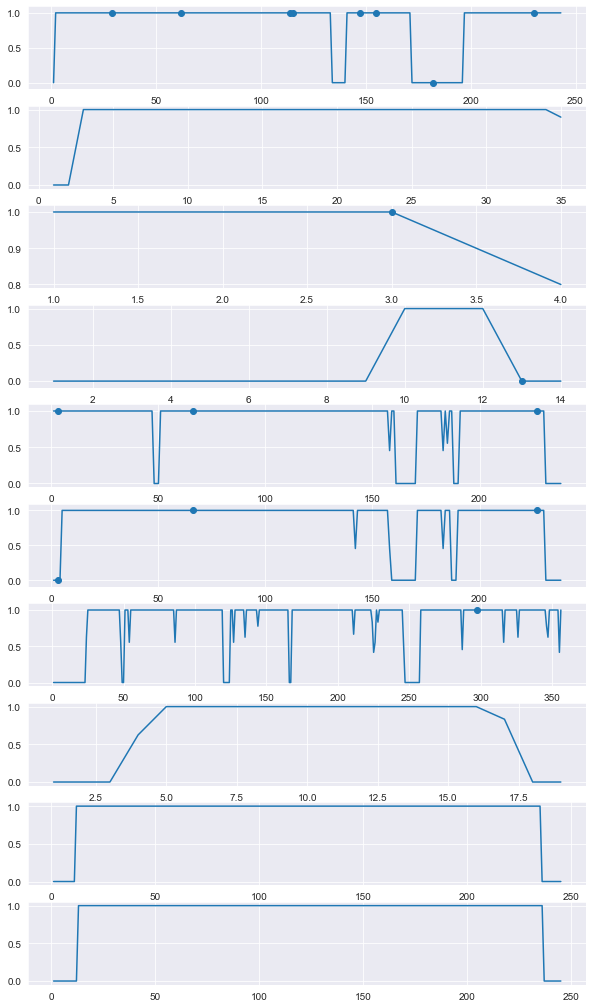

In [135]:
groups = pro_dfrm67.groupby(['pdb_id','chain_id', 'entity_id'])
figure, ax=plt.subplots(10, 1, figsize=(10,18))
count = 0
for i, j in groups:
    label = '%s_%s_%s' % i
    #if len(j.residue_number) < 20:
    #    continue
    handle, = ax[count].plot(j.residue_number, j.observed_ratio, label=label)
    mod = j.dropna(subset=['chem_comp_id'])
    print(f'{label}->atom_len:{len(j[j.observed_ratio.gt(0)])-len(mod[mod.observed_ratio.gt(0)])}')
    if len(mod.residue_number) > 0:
        ax[count].scatter(mod.residue_number, mod.observed_ratio)
    count += 1
    if count == 10:
        break

In [73]:
dfrm8 = ProcessEntryData.main(
    pdb_col='pdb_id',
    filters={'sifts_range_tage': ('eq', 'Safe'), 'delete': ('ne', True)},
    dfrm=dfrm,
    suffix='pdb/entry/files/',
    method='post',
    folder=r'C:\GitWorks\Muta3DMaps\Muta3DMaps\test\data'
)
dfrm8

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.69s/it]
2020-02-20 11:32:20,547 ProcessEntryData INFO 1 ids downloaded in 2.71s


,label,url,innerKey,key,pdb_id
0,EDS map,http://www.ebi.ac.uk/pdbe/coordinates/files/3e...,downloads,map,3eu7
1,EDS difference map,http://www.ebi.ac.uk/pdbe/coordinates/files/3e...,downloads,map,3eu7
2,Assembly composition XML,http://www.ebi.ac.uk/pdbe/static/entry/downloa...,downloads,assembly,3eu7
3,Assembly 1 (mmCIF; gz),http://www.ebi.ac.uk/pdbe/static/entry/downloa...,downloads,assembly,3eu7
4,Assembly 1 (atom only; mmCIF),http://www.ebi.ac.uk/pdbe/static/entry/downloa...,downloads,assembly,3eu7
...,...,...,...,...,...
166,Structure Factors,http://www.ebi.ac.uk/pdbe/entry-files/download...,downloads,PDB,1n0w
167,Archive mmCIF file,http://www.ebi.ac.uk/pdbe/entry-files/1n0w.cif,views,PDB,1n0w
168,Updated mmCIF file,http://www.ebi.ac.uk/pdbe/entry-files/1n0w_upd...,views,PDB,1n0w
169,PDB file,http://www.ebi.ac.uk/pdbe/entry-files/pdb1n0w.ent,views,PDB,1n0w


In [76]:
# test
path1 = r'C:\OmicData\LiGroupWork\2020_02_20_test\temp_1.tsv'
path2 = r'C:\OmicData\LiGroupWork\2020_02_20_test\temp_2.tsv'
dfrm_test_1 = pd.read_csv(path1, sep='\t', converters={'pdb_id': str})
dfrm_test_2 = pd.read_csv(path2, sep='\t')

In [77]:
pd.merge(dfrm_test_1, dfrm_test_2)

,author_insertion_code,author_residue_number,multiple_conformers,observed_ratio,residue_name,residue_number,chain_id,struct_asym_id,entity_id,pdb_id,chem_comp_id


In [78]:
set1=set(dfrm_test_1.pdb_id)

In [79]:
set2=set(dfrm_test_2.pdb_id)

In [81]:
set1&set2

set()

In [70]:
set_cur = {'2esm', '2pcx', '5kkt', '5wne', '4yve', '3f7p', '5hvu', '2b9e', '4ibw', '4q58', '3igl', '5f5p', '3d09', '2etr', '4lof', '2n03', '2bip', '2etk', '2v55', '2odu', '3igk', '5kks', '3d9v', '2biq', '1mb8', '4yvc', '5uzj', '3v8s', '1s1c', '3d05', '5wnf', '3ndm', '3twj', '4ibv', '4w7p', '3d06', '2bin', '4mzi', '3ncz', '2fej', '3tv7', '5wng', '3o0z', '3d08', '2bio', '5wnh', '4l2w', '2odv', '5bml', '4gdo'}

In [80]:
set1==set_cur

True